### IMPORT PYTHON MODULES FOR PREPROCESSING, MODELLING AND VISUALIZATION

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression as MaximumEntropy
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn import metrics
%matplotlib inline

In [3]:
import spacy as sp

In [4]:
#read the csv_file into a pandas dataframe
data = pd.read_csv(r"DATA.csv")

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176749 entries, 0 to 176748
Data columns (total 29 columns):
SR_ID                         20082 non-null object
ACCOUNT_NAME                  19869 non-null object
SR_FIRST_CREATED_DATE         20082 non-null object
ACTION_TAKEN_TEXT             20082 non-null object
ISSUE_TYPE                    19917 non-null object
SUB_ISSUE_TYPE                19917 non-null object
INITIAL_EMAIL_SUBJECT_LINE    19871 non-null object
CONTACT_EMAIL_ADDRESS         15425 non-null object
SUPPLIED_EMAIL_ADDRESS        19893 non-null object
EMAIL_TEXT                    20082 non-null object
SERVICE_REGION                18836 non-null object
SALES_OFFICE                  20057 non-null object
EMAIL_PRIORITY                20082 non-null object
EMAIL_CC_LIST                 4913 non-null object
EMAIL_TO_LIST                 19873 non-null object
STATUS                        20082 non-null object
CUSTOMER_AGE_SEGMENT          19636 non-null object
EMPLOY

In [0]:
#get non-null value
data = data[0:20082]

##### GET THE IMPORTANT FEATURES FROM THE DATASET 

In [0]:
#get important features
data_important = data[['EMAIL_TEXT','INITIAL_EMAIL_SUBJECT_LINE','ACTION_TAKEN_TEXT','ISSUE_TYPE', 'SUB_ISSUE_TYPE']]

In [8]:
#check five rows in the dataset
data_important.head()

,EMAIL_TEXT,INITIAL_EMAIL_SUBJECT_LINE,ACTION_TAKEN_TEXT,ISSUE_TYPE,SUB_ISSUE_TYPE
0,"Hello,\r\n\r\nI am following up on the email I...",RE: 10 Tanker Air Carrier/Employee Heather Sva...,Resolved within Ask Unum,Ongoing Employee Maintenance,Enrollment Status
1,CAUTION EXTERNAL EMAIL: This email originated ...,Enrollment Request 565927 (PYCHX# 2165487),Referred to Service Center for coding,Ongoing Employee Maintenance,Enrollment Submission
2,Name: FIRST_NAME Grimmette\r\n\r\nPhone: PHON...,Ask Policy or Billing Questions,Resolved within Ask Unum,Ongoing Employee Maintenance,Coding Change or Correction
3,Claim Form for EE FIRST_NAME LAST_NAME SSN \r...,0218584 Life Insurance Claim Form,Referred to DBS (Claims),Claims,New Claim Submission
4,This message originated outside of Unum. Use c...,Ike Gaming Inc dba El Cortez - Enrollment & Te...,Referred to Service Center for coding,Ongoing Employee Maintenance,Employee Coding


##### CONVERT THE FEATURES TO BE CONCANTENATED TO SRTINGS

In [9]:
data_important['EMAIL_TEXT'] = data_important['EMAIL_TEXT'].apply(lambda x: str(str(x).lower()))
data_important['INITIAL_EMAIL_SUBJECT_LINE'] = data_important['INITIAL_EMAIL_SUBJECT_LINE'].apply(lambda x: str(str(x).lower()))
data_important['ACTION_TAKEN_TEXT'] = data_important['ACTION_TAKEN_TEXT'].apply(lambda x: str(str(x).lower()))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

##### CONCAT EMAIL_TEXT, ACTION_TAKEN, AND INITIAL_EMAIL_SUBJECT_LINE AS ONE

In [10]:
#columns concantenation
data_important['merged_text'] = data_important['INITIAL_EMAIL_SUBJECT_LINE'] + '' + data_important['EMAIL_TEXT'] + '' + data_important['ACTION_TAKEN_TEXT']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [11]:
data_important.head()

,EMAIL_TEXT,INITIAL_EMAIL_SUBJECT_LINE,ACTION_TAKEN_TEXT,ISSUE_TYPE,SUB_ISSUE_TYPE,merged_text
0,"hello,\r\n\r\ni am following up on the email i...",re: 10 tanker air carrier/employee heather sva...,resolved within ask unum,Ongoing Employee Maintenance,Enrollment Status,re: 10 tanker air carrier/employee heather sva...
1,caution external email: this email originated ...,enrollment request 565927 (pychx# 2165487),referred to service center for coding,Ongoing Employee Maintenance,Enrollment Submission,enrollment request 565927 (pychx# 2165487)caut...
2,name: first_name grimmette\r\n\r\nphone: phon...,ask policy or billing questions,resolved within ask unum,Ongoing Employee Maintenance,Coding Change or Correction,ask policy or billing questionsname: first_nam...
3,claim form for ee first_name last_name ssn \r...,0218584 life insurance claim form,referred to dbs (claims),Claims,New Claim Submission,0218584 life insurance claim formclaim form fo...
4,this message originated outside of unum. use c...,ike gaming inc dba el cortez - enrollment & te...,referred to service center for coding,Ongoing Employee Maintenance,Employee Coding,ike gaming inc dba el cortez - enrollment & te...


In [12]:
#check the values in ISSUE_TYPE
pd.DataFrame(data_important.ISSUE_TYPE.unique()).values

array([['Ongoing Employee Maintenance'],
       ['Claims'],
       ['Website'],
       ['Plan Inquiry'],
       ['Forms and Copies'],
       ['Billing'],
       ['Plan Updates and Changes'],
       ['Broker'],
       ['Proactive Outreach'],
       [nan],
       ['Quick Call']], dtype=object)

In [13]:
data_important.isnull().sum()

EMAIL_TEXT                      0
INITIAL_EMAIL_SUBJECT_LINE      0
ACTION_TAKEN_TEXT               0
ISSUE_TYPE                    165
SUB_ISSUE_TYPE                165
merged_text                     0
dtype: int64

### PROCESSING OF THE TARGET FEATURE BY SPLITTING THE DATA INTO 6 ISSUE_TYPE AND USING REGEX TO FORM 17 CATEGORIES OF SUB_ISSUE_TYPE, WHICH WOULD BE OUR TARGET FOR TEXT CLASSIFICATION

In [0]:
data_1 = data_important[data_important['ISSUE_TYPE']=='Ongoing Employee Maintenance']

In [0]:
data_2 = data_important[data_important['ISSUE_TYPE'] == 'Plan Inquiry']

In [0]:
data_3 = data_important[data_important['ISSUE_TYPE'] == 'Forms and Copies']

In [0]:
data_4 = data_important[data_important['ISSUE_TYPE']== 'Billing']

In [0]:
data_5 = data_important[data_important['ISSUE_TYPE'].isnull()]

In [0]:
data_6 = data_important[(data_important['ISSUE_TYPE'] == 'Claims')|(data_important['ISSUE_TYPE'] =='Website')|(data_important['ISSUE_TYPE'] == 'Plan Updates and Changes')|(data_important['ISSUE_TYPE']=='Broker')|(data_important['ISSUE_TYPE']=='Proactive Outreach')]

In [0]:
#A regular expression is a special sequence of characters that helps you match or find other strings or 
# sets of strings, using a specialized syntax held in a pattern. 
import re

In [0]:
#sub_issue is a parameter that represent the sub_issue_type column
def get_sub_issue_1(sub_issue):
            sub_issue = str(sub_issue)
            if re.search('invoice|inventory|report|forms|document|sheet|benefit summary|bor packet|booklet|census listing|claim form|benefit summary|experience|beneficiary', sub_issue.lower()):
                return 'Forms and Copies - Booklet'
            elif re.search('contract|rate|confirmation', sub_issue.lower()):
                return 'Forms and Copies - Contract'
            elif re.search('enrollment', sub_issue.lower()):
                return 'Forms and Copies - Enrollment'
            elif re.search('evidence|dental', sub_issue.lower()):
                return 'Forms and Copies - Evidence of Insurability'
            else:
                return 'Forms and Copies - Schedule A'

In [22]:
data_3['Target'] = data_3['SUB_ISSUE_TYPE'].apply(get_sub_issue_1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
def get_sub_issue_2(sub_issue):
            sub_issue = str(sub_issue)
            
            if re.search('customer', sub_issue.lower()):
                return 'Ongoing Employee Maintenance - Coding Correction - Customer Error'
            elif re.search('employee', sub_issue.lower()):
                return 'Ongoing Employee Maintenance - Employee Coding' 
            elif re.search('enrollment status|open enrollment', sub_issue.lower()):
                return 'Ongoing Employee Maintenance - Enrollment Status'
            elif re.search('or', sub_issue.lower()):
                 return 'Ongoing Employee Maintenance - Coding Change or Correction'
            elif re.search('submission', sub_issue.lower()):
                return 'Ongoing Employee Maintenance - Enrollment Submission'
            elif re.search('eoi status|inquiry', sub_issue.lower()):
                return 'Ongoing Employee Maintenance - EOI Status'
            elif re.search('internal|datafeed|information|', sub_issue.lower()):
                return 'Ongoing Employee Maintenance - Coding Correction - Internal Error'
            else:
                return 'Ongoing Employee Maintenance - EOI Submission'

In [24]:
data_1['Target'] = data_1['SUB_ISSUE_TYPE'].apply(get_sub_issue_2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
def get_sub_issue_3(sub_issue):
            sub_issue = str(sub_issue)
            
            if re.search('payment status|premium|ach|charge or credit clarification|employee coding discrepancy|bill|refund|missing or skipped payment|late notice or collections',sub_issue.lower()):
                return 'Billing - ACH Inquiry/Confirmation'
            else:
                return 'Billing - ACH Inquiry/Confirmation'

In [26]:
data_4['Target'] = data_4['SUB_ISSUE_TYPE'].apply(get_sub_issue_3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
def get_sub_issue_4(sub_issue):
        sub_issue = str(sub_issue)
        if re.search('contract provision inquiry|renewal inquiry|portability or conversion|tax question|db120|long term care|quote|less than minimum lives|rfp|mass mailing', sub_issue.lower()):
            return 'Plan Inquiry - Renewal Inquiry'
        else:
            return 'Plan Inquiry - Renewal Inquiry'
        

In [28]:
data_2['Target'] = data_2['SUB_ISSUE_TYPE'].apply(get_sub_issue_4)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
def get_sub_issue_5(sub_issue):
    sub_issue = str(sub_issue)
    if re.search(' ', sub_issue.lower()):
        return 'Withdrawn'
    else:
        return 'Withdrawn'

In [30]:
data_5['Target'] = data_5['SUB_ISSUE_TYPE'].apply(get_sub_issue_5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [31]:
data_6['Target'] = data_6['SUB_ISSUE_TYPE'].apply(lambda x: 'Others')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


#### CONCAT ALL 6 DATASETS INTO ONE DATAFRAME NAMED data_processed

In [0]:
#combine the 6 dataframes created for each of the issue-type
data_processed = pd.concat([data_1, data_2, data_3, data_4, data_5, data_6])

In [33]:
data_processed['Target'].value_counts()

Others                                                               4526
Ongoing Employee Maintenance - Employee Coding                       3592
Ongoing Employee Maintenance - Enrollment Submission                 3241
Forms and Copies - Booklet                                           1811
Plan Inquiry - Renewal Inquiry                                       1751
Ongoing Employee Maintenance - Enrollment Status                     1371
Billing - ACH Inquiry/Confirmation                                   1294
Forms and Copies - Contract                                           563
Ongoing Employee Maintenance - Coding Change or Correction            543
Ongoing Employee Maintenance - EOI Status                             428
Forms and Copies - Enrollment                                         227
Ongoing Employee Maintenance - Coding Correction - Customer Error     209
Forms and Copies - Schedule A                                         179
Withdrawn                             

In [34]:
data_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20079 entries, 0 to 20074
Data columns (total 7 columns):
EMAIL_TEXT                    20079 non-null object
INITIAL_EMAIL_SUBJECT_LINE    20079 non-null object
ACTION_TAKEN_TEXT             20079 non-null object
ISSUE_TYPE                    19914 non-null object
SUB_ISSUE_TYPE                19914 non-null object
merged_text                   20079 non-null object
Target                        20079 non-null object
dtypes: object(7)
memory usage: 1.2+ MB


In [35]:
# Create a new column 'category_id' with encoded categories 
data_processed['category_id'] = data_processed['Target'].factorize()[0]
category_id_df = data_processed[['Target', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Target']].values)

# New dataframe
data_processed.head()

,EMAIL_TEXT,INITIAL_EMAIL_SUBJECT_LINE,ACTION_TAKEN_TEXT,ISSUE_TYPE,SUB_ISSUE_TYPE,merged_text,Target,category_id
0,"hello,\r\n\r\ni am following up on the email i...",re: 10 tanker air carrier/employee heather sva...,resolved within ask unum,Ongoing Employee Maintenance,Enrollment Status,re: 10 tanker air carrier/employee heather sva...,Ongoing Employee Maintenance - Enrollment Status,0
1,caution external email: this email originated ...,enrollment request 565927 (pychx# 2165487),referred to service center for coding,Ongoing Employee Maintenance,Enrollment Submission,enrollment request 565927 (pychx# 2165487)caut...,Ongoing Employee Maintenance - Enrollment Subm...,1
2,name: first_name grimmette\r\n\r\nphone: phon...,ask policy or billing questions,resolved within ask unum,Ongoing Employee Maintenance,Coding Change or Correction,ask policy or billing questionsname: first_nam...,Ongoing Employee Maintenance - Coding Change o...,2
4,this message originated outside of unum. use c...,ike gaming inc dba el cortez - enrollment & te...,referred to service center for coding,Ongoing Employee Maintenance,Employee Coding,ike gaming inc dba el cortez - enrollment & te...,Ongoing Employee Maintenance - Employee Coding,3
10,caution external email: this email originated ...,re: fwd: #secure urgent escalated client- open...,resolved within ask unum,Ongoing Employee Maintenance,Employee Coding,re: fwd: #secure urgent escalated client- open...,Ongoing Employee Maintenance - Employee Coding,3


In [36]:
#the different catergories and their id 
category_id_df

,Target,category_id
0,Ongoing Employee Maintenance - Enrollment Status,0
1,Ongoing Employee Maintenance - Enrollment Subm...,1
2,Ongoing Employee Maintenance - Coding Change o...,2
4,Ongoing Employee Maintenance - Employee Coding,3
77,Ongoing Employee Maintenance - Coding Correcti...,4
82,Ongoing Employee Maintenance - EOI Status,5
626,Ongoing Employee Maintenance - Coding Correcti...,6
7,Plan Inquiry - Renewal Inquiry,7
8,Forms and Copies - Booklet,8
43,Forms and Copies - Contract,9


###### CHECK THE FREQUENCY OF THE DIFFERENT SUB_ISSUE_TYPE THAT WAS CREATED"

Text(0.5, 0, 'Number of ocurrences')

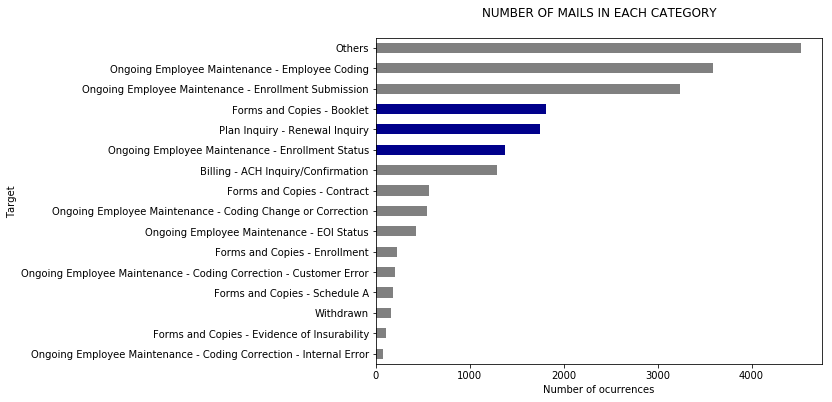

In [37]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
data_processed.groupby('Target').merged_text.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF MAILS IN EACH CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10)

### DATA PREPROCESSING OF THE merged_text

In [38]:
#convert all alphabets to small letters
data_processed['merged_text'] = data_processed['EMAIL_TEXT'].apply(lambda x: " ".join(str(x).lower() for x in str(x).split()))
data_processed['merged_text'].head()

0     hello, i am following up on the email i sent j...
1     caution external email: this email originated ...
2     name: first_name grimmette phone: phone_number...
4     this message originated outside of unum. use c...
10    caution external email: this email originated ...
Name: merged_text, dtype: object

In [39]:
#replaced all characters with space
data_processed['merged_text'] = data_processed['merged_text'].str.replace('[^\w\s]','')
data_processed['merged_text'].head(20)

0     hello i am following up on the email i sent ju...
1     caution external email this email originated f...
2     name first_name grimmette phone phone_number r...
4     this message originated outside of unum use ca...
10    caution external email this email originated f...
14    this message originated outside of unum use ca...
16    first_name first_name ssn ssn friday ezerendu ...
17    caution external email this email originated f...
18    brandon loper ssn hi team can you please proce...
19    this message originated outside of unum use ca...
21    good afternoon please have the attached enroll...
23    this message originated outside of unum use ca...
28    ________________________________ from unum evi...
34    hello please see highlighted below for the las...
35    caution external email this email originated f...
36    this message originated outside of unum use ca...
37    re 952779 hi ask unum please process the attac...
38    this message originated outside of unum us

In [40]:
#To check if the characters that were removed was truly removed.
data_processed['merged_text'][2]

'name first_name grimmette phone phone_number response requested by email policy and division  phone_number 001 company name the kaufmann clinic comment employee ronson last_name dob 022789 ssn ssn was effective 051518 he received his dental cards in the mail but his name is spelled incorrectly his name is ronson not last_name can you please correct this and reissue him new cards thank you'

In [0]:
#import stop words from sklearn
from sklearn.feature_extraction import stop_words
 
stop = stop_words.ENGLISH_STOP_WORDS

In [42]:
#remove stop words, as they are not informative enough for prediction
data_processed['merged_text'] = data_processed['merged_text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
data_processed['merged_text'].head()

0     hello following email sent june 28th advise fi...
1     caution external email email originated outsid...
2     first_name grimmette phone phone_number respon...
4     message originated outside unum use caution op...
10    caution external email email originated outsid...
Name: merged_text, dtype: object

In [5]:
!pip install spacy

In [7]:
!python -m spacy download en
#!conda install -c conda-forge spacy

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/home/esa/anaconda3/lib/python3.6/site-packages/en_core_web_sm -->
/home/esa/anaconda3/lib/python3.6/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [8]:
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [0]:
import spacy
spacy_tok = spacy.load('en_core_web_sm')

In [0]:
import string

#### FURTHER TEXT PREPROCESSING WITH SPACY(LEMMATIZATION AND TOKENIZATION)

In [0]:
# Define function to cleanup text by removing personal pronouns, word lemmatization, tokenization and removal of punctuations
nlp = spacy.load('en_core_web_sm')
punctuations = string.punctuation
def cleanup_text(doc, logging=False):
      doc = nlp(doc, disable=['parser', 'ner'])
      tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
      tokens = [tok for tok in tokens if tok not in punctuations]
      tokens = ' '.join(tokens)
      return tokens


data_processed['merged_text'] = data_processed['merged_text'].apply(cleanup_text)


In [0]:
#remove numbers as they are not informative
data_processed['merged_text'] = data_processed['merged_text'].apply(lambda x: re.sub(r'[0-9]+', '', x))

In [47]:
data_processed['merged_text']

0        hello follow email send june th advise first_n...
1        caution external email email originate outside...
2        first_name grimmette phone phone_number respon...
4        message originate outside unum use caution ope...
10       caution external email email originate outside...
14       message originate outside unum use caution ope...
16       first_name first_name ssn ssn friday ezerendu ...
17       caution external email email originate outside...
18       brandon loper ssn hi team process employee ter...
19       message originate outside unum use caution ope...
21       good afternoon attach enrollment form process ...
23       message originate outside unum use caution ope...
28       unum evidence insurability send thursday janua...
34       hello highlight day work first_name orduno tha...
35       caution external email email originate outside...
36       message originate outside unum use caution ope...
37        hi ask unum process attach enrollment form te.

In [48]:
# Model: Bag-of-words

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(data_processed['merged_text']).toarray()
labels = data_processed.category_id
features.shape

(20079, 56054)

In [0]:
# Use 'sklearn.feature_selection.chi2' to find the terms that are the most correlated with each of the targets

from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Target, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("--> '{}':".format(Target))
    print("  . Most Correlated Unigrams are :\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most Correlated Bigrams are :\n. {}".format('\n. '.join(bigrams[-N:])))

--> 'Billing - ACH Inquiry/Confirmation':
  . Most Correlated Unigrams are :
. remittance
. payment
  . Most Correlated Bigrams are :
. remittance advice
. attach remittance
--> 'Forms and Copies - Booklet':
  . Most Correlated Unigrams are :
. census
. recent
  . Most Correlated Bigrams are :
. send recent
. recent invoice
--> 'Forms and Copies - Contract':
  . Most Correlated Unigrams are :
. contract
. rate
  . Most Correlated Bigrams are :
. contract rate
. certificate coverage
--> 'Forms and Copies - Enrollment':
  . Most Correlated Unigrams are :
. residence
. situs
  . Most Correlated Bigrams are :
. customer policy
. state residence
--> 'Forms and Copies - Evidence of Insurability':
  . Most Correlated Unigrams are :
. aprylyamnitzbuchheitscom
. card
  . Most Correlated Bigrams are :
. dental card
. vision card
--> 'Forms and Copies - Schedule A':
  . Most Correlated Unigrams are :
. wallet
. eap
  . Most Correlated Bigrams are :
. provide schedule
. wallet card
--> 'Ongoing Em

### TEXT TRANSFORMATION AND MODEL BUILDING

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(data_processed['merged_text'], data_processed['Target'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [50]:
print(clf.predict(count_vect.transform(["enrollment request 565927 pychx 2165487caution"])))

['Ongoing Employee Maintenance - Enrollment Submission']


## SVM, MULTINOMIAL NAIVE BAYES AND MAXIMUMENTROPY(LOGISTIC REGRESSION) MODELS AND PERFORMANCE ACCURACY

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

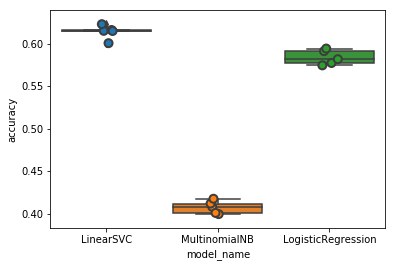

In [51]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    
    LinearSVC(),
    MultinomialNB(),
    MaximumEntropy()
]
CV = 5 # We can use any cross validation number, but 5 is usually a standard it reduces over-fitting while it saves time
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
         entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [52]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC             0.613878
LogisticRegression    0.583744
MultinomialNB         0.407540
Name: accuracy, dtype: float64

#### SVM MODEL WITH PERFORMANCE VISUALIZATION

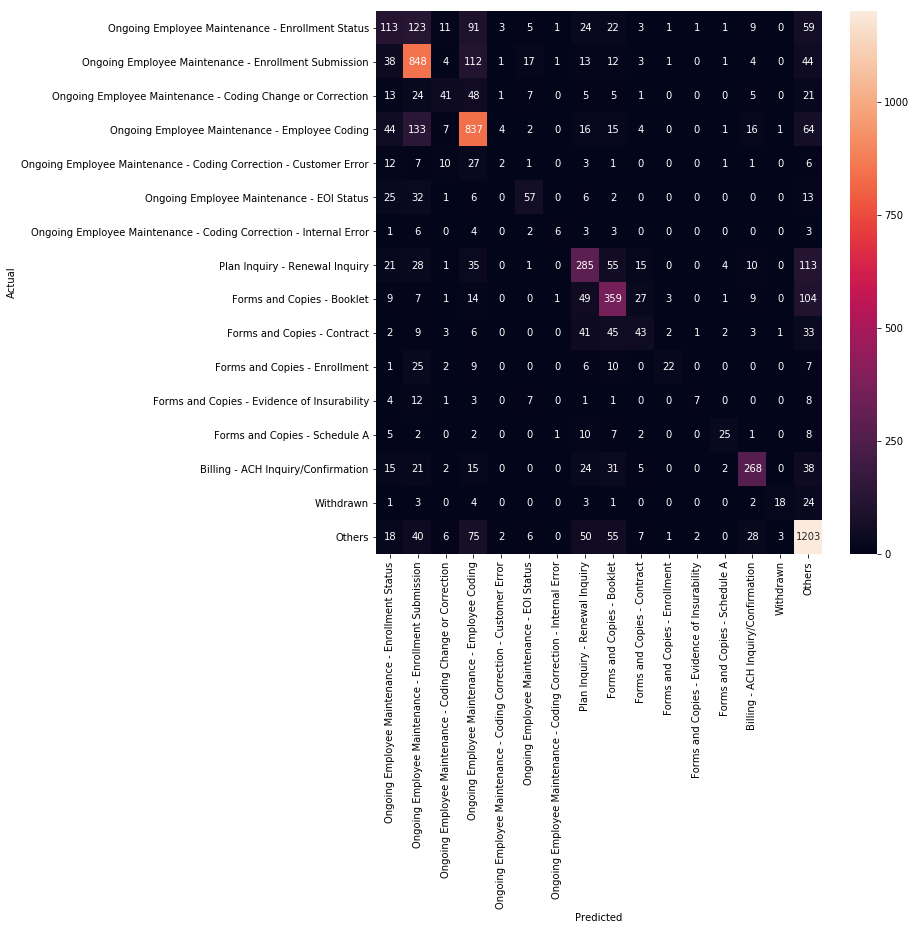

In [53]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, data_processed.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Target.values, yticklabels=category_id_df.Target.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [58]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.35      0.24      0.29       467
           1       0.64      0.77      0.70      1099
           2       0.46      0.24      0.31       171
           3       0.65      0.73      0.69      1144
           4       0.15      0.03      0.05        71
           5       0.54      0.40      0.46       142
           6       0.60      0.21      0.32        28
           7       0.53      0.50      0.51       568
           8       0.58      0.61      0.59       584
           9       0.39      0.23      0.29       191
          10       0.73      0.27      0.39        82
          11       0.64      0.16      0.25        44
          12       0.66      0.40      0.50        63
          13       0.75      0.64      0.69       421
          14       0.78      0.32      0.46        56
          15       0.69      0.80      0.74      1496

    accuracy                           0.62      6627
   macro avg       0.57   

## MaximumEntropy is the same as LogisticRegression(https://www.quora.com/What-is-the-relationship-between-Log-Linear-model-MaxEnt-model-and-Logistic-Regression)